In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings

warnings.filterwarnings("ignore")


In [2]:
s, x,z,y= generate_data_survivl(n=10000,T=5)
np.mean(y[x[:,0]==1,2])-np.mean(y[x[:,0]==0,2])
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)

In [4]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(x=x,z=z,y=y,num_iters=5000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 6.2242,	loss_y 4.1416, 4.1765, 0.0696,	loss_eta 2.0826, 2.1400, 0.1149
Epoch 1000: loss 3.3499,	loss_y 1.8431, 3.6658, 3.6455,	loss_eta 1.5068, 3.0075, 3.0015
Epoch 2000: loss 3.3593,	loss_y 1.8600, 3.6882, 3.6564,	loss_eta 1.4993, 3.0002, 3.0018
Epoch 3000: loss 3.3383,	loss_y 1.8403, 3.6680, 3.6553,	loss_eta 1.4980, 2.9967, 2.9974
Epoch 4000: loss 3.3461,	loss_y 1.8333, 3.6318, 3.5970,	loss_eta 1.5128, 2.9921, 2.9584
Epoch 5000: loss 3.3408,	loss_y 1.8249, 3.6377, 3.6257,	loss_eta 1.5160, 3.0036, 2.9753


In [9]:
model.predict_causal(x=torch.tensor([[1,1,1,1,1]]), sample_size=1000)

[tensor([[1.4195]]),
 tensor([[1.8275]]),
 tensor([[2.4225]]),
 tensor([[2.2972]]),
 tensor([[2.1968]])]

In [13]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1,1,1,1,1]]), sample_size=1000)

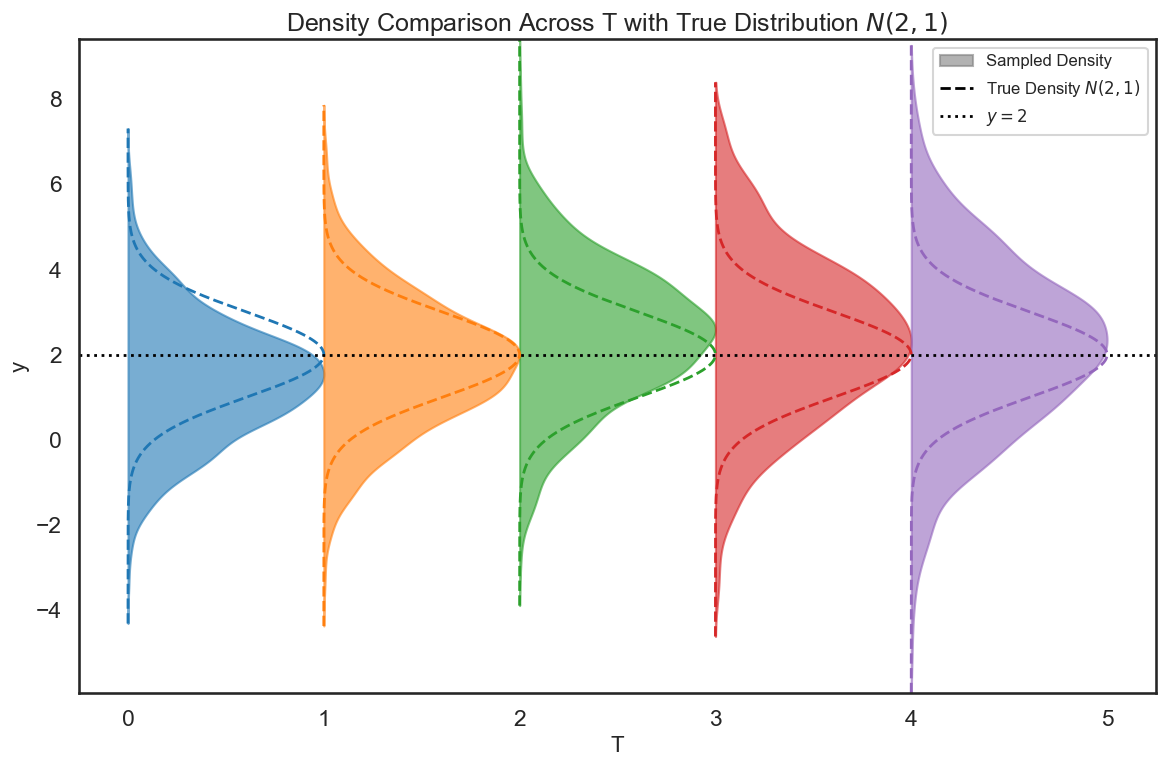

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(5)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()
